In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

from data import get_loaders, load_dataset
from definitions import device, DATASETS
from utils import print_losses
from models import create_model, load_model
from metrics import RMSE
from training import get_test_predictions, test_step

In [2]:
# def test_step(batch_x: torch.Tensor, batch_y: torch.Tensor, model: nn.Module, criterion):
#     outputs = model(batch_x.to(device))
#     loss = criterion(outputs, batch_y.to(device))
#     return loss.item()


# def get_test_predictions(
#     x_train: np.array, y_train: np.array, x_test: np.array, y_test: np.array, model: nn.Module, batch_size: int = 100
# ):
#     _, test_loader = get_loaders(x_train, y_train, x_test, y_test, batch_size)
#     test_predictions = [model(batch_x.to(device)).cpu().detach().numpy() for batch_x, _ in test_loader]
#     return np.concatenate(test_predictions)


In [3]:
class NoisyAdam:
    def __init__(self, model, criterion, N, alpha, beta1, beta2, lambda_, eta, gamma_ex):
        self.criterion = criterion
        self.N = N
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.lambda_ = lambda_
        self.eta = eta
        self.gamma_ex = gamma_ex
        self.mu = nn.utils.parameters_to_vector(model.parameters()).detach().cpu().clone()
        self.f = torch.zeros_like(self.mu) + 1e4
        self.m = torch.zeros_like(self.mu)
        self.gamma_in = self.lambda_ / (self.N * self.eta)
        self.gamma = self.gamma_in + self.gamma_ex
        self.k = 0
#         print(self.__dict__)
        
    def sample_model_weights(self, model):
#         print(self.mu)
        covarince_m = self.lambda_ / self.N * torch.diag(1 / (self.f + self.gamma_in))
        distribution = torch.distributions.MultivariateNormal(self.mu, covariance_matrix=covarince_m)
        w = distribution.sample()
        return w
        
    def zero_grad(self, model):
        for p in model.parameters():
            if p.grad is not None:
                p.grad.data.zero_()
            
    def get_grads(self, model):
        return torch.cat([p.grad.reshape(-1) for p in model.parameters()])
    
    def get_mu_model(self, model):
        torch.nn.utils.vector_to_parameters(self.mu, model.parameters())
        model.to(device)
        return model
    
    def sample_posterior(self, x_train, y_train, x_test, y_test, model, S):
        test_predictions_list = []
        for _ in range(S):
            w = self.sample_model_weights(model)
            torch.nn.utils.vector_to_parameters(w, model.parameters())
            model.to(device)
            test_predictions_list.append(get_test_predictions(x_train, y_train, x_test, y_test, model))
        return test_predictions_list
    
    def step(self, model, batch_x, batch_y):
        self.k += 1
        
        w = self.sample_model_weights(model)
        torch.nn.utils.vector_to_parameters(w, model.parameters())
        model.to(device)
        
        self.zero_grad(model)
        pred_y = model(batch_x.to(device))
        loss = self.criterion(pred_y, batch_y)
        loss.backward()
        grads = -self.get_grads(model).detach().cpu().clone()

        v = grads + self.gamma * w
        
#         print(f"v: {v}")
        
        self.m = self.beta1 * self.m + (1 - self.beta1) * v
#         print(f"m: {self.m}")
        
        self.f = self.beta2 * self.f + (1 - self.beta2) * grads**2
#         print(f"f: {self.f}")
        
        m_tilde = self.m / (1. - self.beta1**self.k)
#         print(f"self.beta1**self.k: {self.beta1**self.k}")
#         print(f"m_tilde: {m_tilde}")

        m_dash = m_tilde / (torch.sqrt(self.f) + self.gamma)
#         print(f"m_dash: {m_dash}")
        
        self.mu = self.mu + self.alpha * m_dash
        
        return loss.item()

dataset: boston_housing, rows: 506, columns: 13, range of x: [0.0, 711.0], range of y: [5.0, 50.0]
Finished Training. Best validation loss: 0.18821 in epoch 22
SGD RMSE: 0.388
RMSE: 0.343, PICP: 0.275, MPIW:0.338


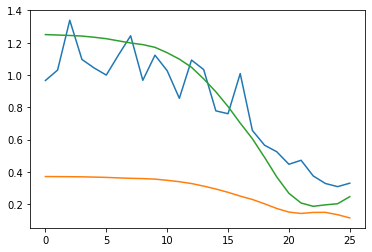

dataset: concrete, rows: 1030, columns: 8, range of x: [0.0, 1145.0], range of y: [2.33, 82.6]
Finished Training. Best validation loss: 0.24883 in epoch 18
SGD RMSE: 0.483
RMSE: 0.526, PICP: 0.495, MPIW:0.816


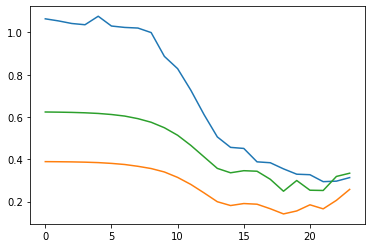

dataset: energy_heating_load, rows: 768, columns: 8, range of x: [0.0, 808.5], range of y: [6.01, 43.1]
Finished Training. Best validation loss: 0.08805 in epoch 22
SGD RMSE: 0.283
RMSE: 0.239, PICP: 0.922, MPIW:1.104


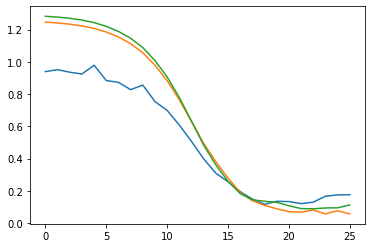

dataset: kin8nm, rows: 8192, columns: 8, range of x: [-1.5706812, 1.5707529], range of y: [0.040165378, 1.4585206]
Finished Training. Best validation loss: 0.15323 in epoch 18
SGD RMSE: 0.396
RMSE: 0.428, PICP: 0.599, MPIW:0.697


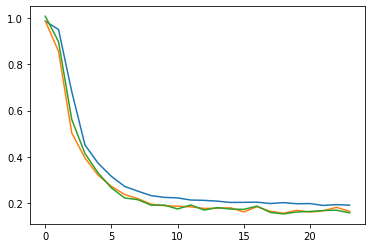

dataset: naval_compressor_decay, rows: 11934, columns: 16, range of x: [0.0, 72784.872], range of y: [0.95, 1.0]
Finished Training. Best validation loss: 0.30483 in epoch 10
SGD RMSE: 0.756
RMSE: 0.702, PICP: 0.003, MPIW:0.301


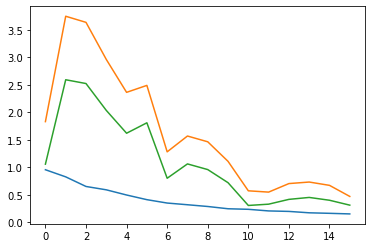

dataset: power, rows: 9568, columns: 4, range of x: [1.81, 1033.3], range of y: [420.26, 495.76]
Finished Training. Best validation loss: 0.05827 in epoch 8
SGD RMSE: 0.247
RMSE: 0.255, PICP: 0.619, MPIW:0.468


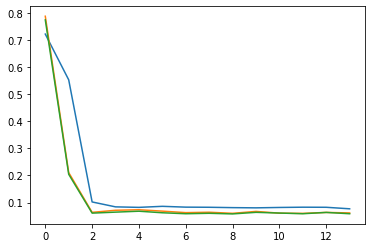

dataset: protein, rows: 45730, columns: 9, range of x: [0.0, 5472011.4075], range of y: [0.0, 20.999]
Finished Training. Best validation loss: 0.56633 in epoch 23
SGD RMSE: 0.752
RMSE: 0.765, PICP: 0.134, MPIW:0.235


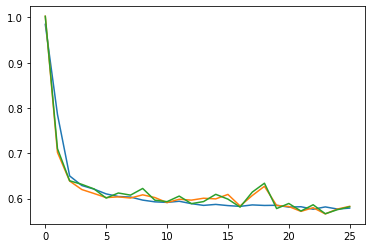

dataset: wine, rows: 1599, columns: 11, range of x: [0.0, 289.0], range of y: [3, 8]
Finished Training. Best validation loss: 0.49549 in epoch 20
SGD RMSE: 0.836
RMSE: 0.810, PICP: 0.406, MPIW:0.885


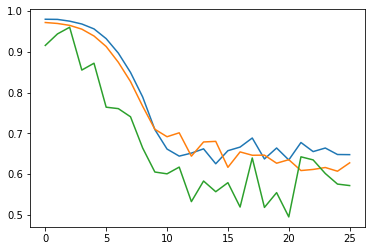

dataset: yacht, rows: 308, columns: 6, range of x: [-5.0, 5.35], range of y: [0.01, 62.42]
Finished Training. Best validation loss: 0.95395 in epoch 25
SGD RMSE: 0.943
RMSE: 0.943, PICP: 0.065, MPIW:0.048


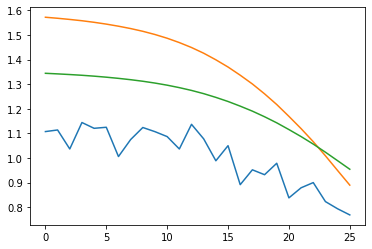

dataset: year_prediction_msd, rows: 515345, columns: 90, range of x: [-14861.69535, 65735.77953], range of y: [1922, 2011]
Finished Training. Best validation loss: 0.66598 in epoch 4
SGD RMSE: 0.830
RMSE: 0.843, PICP: 0.086, MPIW:0.157


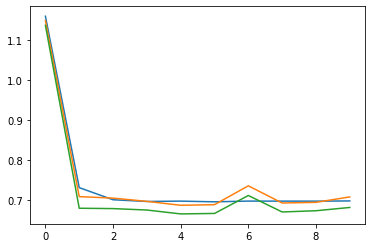

In [4]:
dataset_name = 'boston_housing'
for dataset_name in DATASETS:
    print("=" * 88)
    weight_decay = 0

    x_train, y_train, x_test, y_test, _, _ = load_dataset(dataset_name)
    batch_size = x_train.shape[0] // 9
    model = create_model(x_train, layer_dims=[50], verbose=False)

    S = 500
    epochs: int = 25
    batch_size: int = 100
    lr: float = 1e-2
    early_stopping_rounds: int = 5
    verbose: bool = False
    momentum = 0
    weight_decay = 0
    beta1 = 0.9
    beta2 = 0.9
    lambda_ = 0.01
    eta = 1e6
    gamma_ex = 1e-12

    train_loader, val_loader, test_loader = get_loaders(x_train, y_train, x_test, y_test, batch_size, val_loader=True)

    criterion = nn.MSELoss()
    best_val_loss = 1e10
    best_epoch = 0

    optimizer = NoisyAdam(model, criterion, x_train.shape[0], lr, beta1, beta2, lambda_, eta, gamma_ex)

    train_losses = [test_step(batch_x, batch_y, model, criterion) for batch_x, batch_y in train_loader]
    val_losses = [test_step(batch_x, batch_y, model, criterion) for batch_x, batch_y in val_loader]
    test_losses = [test_step(batch_x, batch_y, model, criterion) for batch_x, batch_y in test_loader]


    loss_list = [[np.mean(train_losses), np.mean(test_losses), np.mean(val_losses)]]

    if verbose:
        print_losses(0, train_losses, test_losses, val_losses)

    for epoch in range(1, epochs + 1):
        train_losses = [optimizer.step(model, batch_x, batch_y.to(device)) for batch_x, batch_y in train_loader ]
        optimizer.get_mu_model(model)
        val_losses = [test_step(batch_x, batch_y, model, criterion) for batch_x, batch_y in val_loader]
        test_losses = [test_step(batch_x, batch_y, model, criterion) for batch_x, batch_y in test_loader]
        if verbose:
            print_losses(epoch, train_losses, test_losses, val_losses)
        loss_list.append([np.mean(train_losses), np.mean(test_losses), np.mean(val_losses)])

        mean_val_loss = np.mean(val_losses)
        if mean_val_loss < best_val_loss:
            torch.save(model.state_dict(), f"best_model_weights-{dataset_name}.pth")
            best_val_loss = mean_val_loss
            best_epoch = epoch

        if epoch - best_epoch >= early_stopping_rounds:
            break
    print(f"Finished Training. Best validation loss: {best_val_loss:.5f} in epoch {best_epoch}")

    model = load_model(model, f"best_model_weights-{dataset_name}.pth", verbose=False)
    y_pred = get_test_predictions(x_train, y_train, x_test, y_test, model)
    print(f"SGD RMSE: {RMSE(y_pred, y_test):.3f}")
    samples = optimizer.sample_posterior(x_train, y_train, x_test, y_test, model, S)
    samples_array = np.concatenate(samples, axis=1)
    y_pred = samples_array.mean(axis=1, keepdims=True)
    y_l = np.percentile(samples_array, 2.5, axis=1, keepdims=True)
    y_u = np.percentile(samples_array, 97.5, axis=1, keepdims=True)
    print(
        f"RMSE: {RMSE(y_pred, y_test):.3f}, PICP: {np.mean((y_l < y_test) & (y_test < y_u)):.3f}, MPIW:{np.mean(y_u - y_l):.3f}"
    )
    plt.plot(np.array(loss_list))
    plt.show()
